In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import glob

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = io*np.pi/180 #np.radians(io) #inclination #25.86
    pa = pa*np.pi/180 #np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

def readmist(file):
    with open(file) as f:
        #lines = f.readlines()
        df = pd.read_csv(file,comment='#',names = ['EEP','log10_isochrone_age_yr','initial_mass',\
                                                   'star_mass','log_Teff','log_g','log_L','FeH_init',\
                                                   'FeH','Bessell_U','Bessell_B','Bessell_V','Bessell_R',\
                                                   'Bessell_I','2MASS_J','2MASS_H','2MASS_Ks','Kepler_Kp',\
                                                   'Kepler_D51','Hipparcos_Hp','Tycho_B','Tycho_V',\
                                                   'Gaia_G_DR2Rev','Gaia_BP_DR2Rev','Gaia_RP_DR2Rev',\
                                                   'Gaia_G_MAW','Gaia_BP_MAWb','Gaia_BP_MAWf','Gaia_RP_MAW',\
                                                   'TESS','phase'],sep='\s+')
        table_out = Table.from_pandas(df)
    return table_out

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
### PARSEC ###

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

### BaSTI ###

#Read in RGB dat file
nom = ['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG','FEH','LOGAGE','LOGG']
bastiall = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/basti_rgb.dat',names=nom)
tbastiall = Table.from_pandas(bastiall)
tempgravcut = np.where((tbastiall['LOGT']<=3.75)&(tbastiall['LOGG']<3.5))
basti = tbastiall[tempgravcut]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist.dr16beta.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits' , 1)
clnpdfout = pdfout[clnr]

### MIST ###

mistall = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST_monarch.dat')
tmistall = Table.from_pandas(mistall)
rgb = np.where((tmistall['EEP']>=495)&(tmistall['EEP']<=605)&(tmistall['log_Teff']<=3.75))
mist = tmistall[rgb]

In [8]:
### Calculate [C/M] and [N/M]
CM = clndr16['C_FE'] + clndr16['FE_H'] - clndr16['M_H']
NM = clndr16['N_FE'] + clndr16['FE_H'] - clndr16['M_H']
al = clndr16['ALPHA_M']

fa = 10**(al)+10**(CM)+10**(NM)

sal(clndr16['M_H'],fa)

array([5.87174  , 3.5687993, 4.563095 , ..., 5.1106377, 3.75001  ,
       4.3422804], dtype=float32)

(array([1.244e+03, 8.880e+02, 1.470e+02, 2.200e+01, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 3.9685607,  6.32153  ,  8.674499 , 11.027468 , 13.380437 ,
        15.733406 , 18.086374 , 20.439344 , 22.792313 , 25.145283 ,
        27.498251 ], dtype=float32),
 <a list of 10 Patch objects>)

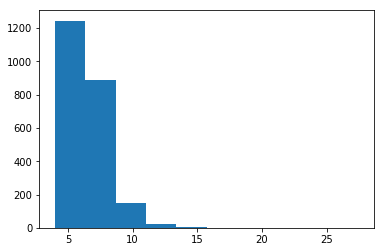

In [10]:
plt.hist(np.log(0.638*(10**(fa))+0.362))

(array([  20.,  165., 1022.,  691.,  196.,  164.,   38.,    7.,    2.,
           2.]),
 array([-0.25632   , -0.134518  , -0.01271601,  0.10908599,  0.23088798,
         0.35268998,  0.47449198,  0.596294  ,  0.71809596,  0.839898  ,
         0.96169996], dtype=float32),
 <a list of 10 Patch objects>)

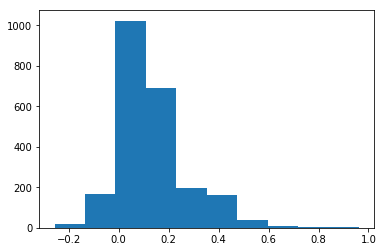

In [12]:
plt.hist(clndr16['N_FE'])

(array([  5.,  13.,  17.,  57., 120., 231., 578., 921., 332.,  33.]),
 array([-2.1124663 , -1.9149823 , -1.7174983 , -1.5200143 , -1.3225303 ,
        -1.1250464 , -0.92756236, -0.73007834, -0.5325943 , -0.3351103 ,
        -0.13762632], dtype=float32),
 <a list of 10 Patch objects>)

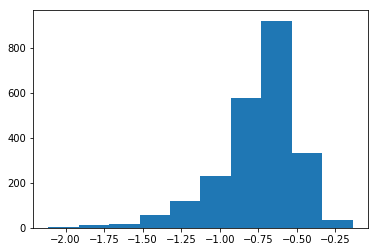

In [13]:
plt.hist(clndr16['FE_H'])

(array([  5.,  10.,  20.,  59., 128., 256., 571., 907., 319.,  32.]),
 array([-2.1842663 , -1.9769703 , -1.7696743 , -1.5623783 , -1.3550823 ,
        -1.1477864 , -0.9404903 , -0.7331943 , -0.52589834, -0.31860232,
        -0.11130632], dtype=float32),
 <a list of 10 Patch objects>)

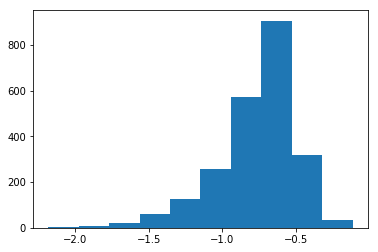

In [14]:
plt.hist(clndr16['M_H'])

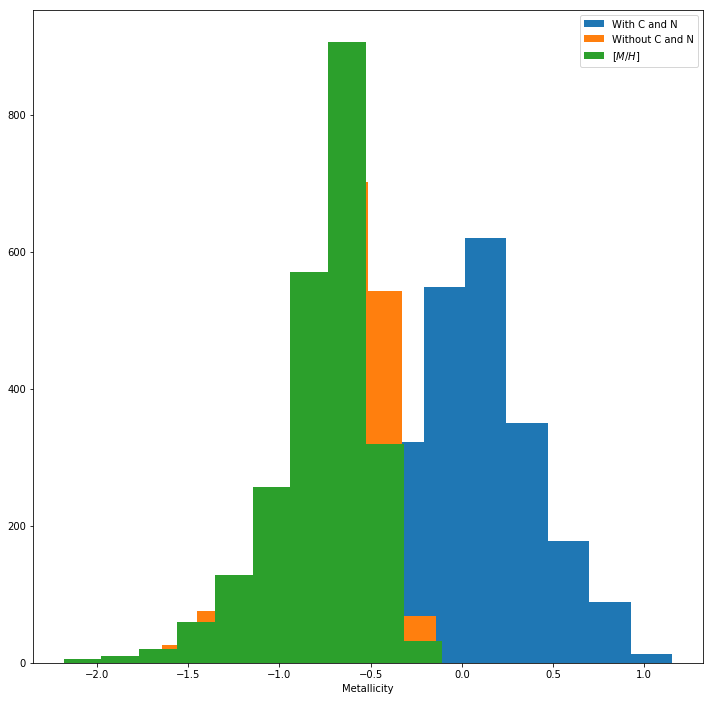

0.055739436

In [15]:
cm = clndr16['C_FE'] + clndr16['FE_H'] - clndr16['M_H']
nm = clndr16['N_FE'] + clndr16['FE_H'] - clndr16['M_H']
newalpha = np.log10(10**clndr16['ALPHA_M']+10**cm+10**nm)

plt.figure(figsize=[12,12])
plt.hist(clndr16['M_H']+np.log(0.638*(10**(newalpha))+0.362),label='With C and N')
plt.hist(clndr16['M_H']+np.log(0.638*(10**(clndr16['ALPHA_M']))+0.362),label='Without C and N')
plt.hist(clndr16['M_H'],label=r'$[M/H]$')
plt.xlabel(r'Metallicity')
plt.legend()
plt.savefig('new_salaris.pdf',bbox_inches='tight')
plt.show()

np.mean(clndr16['M_H']+np.log(0.638*(10**(newalpha))+0.362))

In [78]:
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)

no_C = []
no_N = []
no_O = []
no_Mg = []
no_Ca = []
no_S = []
no_Si = []
no_Fe = []

for i in range(len(clndr16)):
    no_C.append(10**(clndr16['C_FE'][i]-clndr16['FE_H'][i]+sol_2_H[0]))
    no_N.append(10**(clndr16['N_FE'][i]-clndr16['FE_H'][i]+sol_2_H[1]))
    no_O.append(10**(clndr16['O_FE'][i]-clndr16['FE_H'][i]+sol_2_H[2]))
    no_Mg.append(10**(clndr16['MG_FE'][i]-clndr16['FE_H'][i]+sol_2_H[3]))
    no_Ca.append(10**(clndr16['CA_FE'][i]-clndr16['FE_H'][i]+sol_2_H[4]))
    no_S.append(10**(clndr16['S_FE'][i]-clndr16['FE_H'][i]+sol_2_H[5]))
    no_Si.append(10**(clndr16['SI_FE'][i]-clndr16['FE_H'][i]+sol_2_H[6]))
    no_Fe.append(10**(clndr16['FE_H'][i]+sol_2_H[7]))
    
f_fact = []

for j in range(len(clndr16)):
    numer = no_C[j]+no_N[j]+no_O[j]+no_Mg[j]+no_Ca[j]+no_S[j]+no_Si[j]+no_Fe[j]
    denom = 10**sol_2_H[0]+10**sol_2_H[1]+10**sol_2_H[2]+10**sol_2_H[3]+10**sol_2_H[4]+10**sol_2_H[5]+\
                   10**sol_2_H[6]+10**sol_2_H[7]
    f_fact.append(numer/denom)

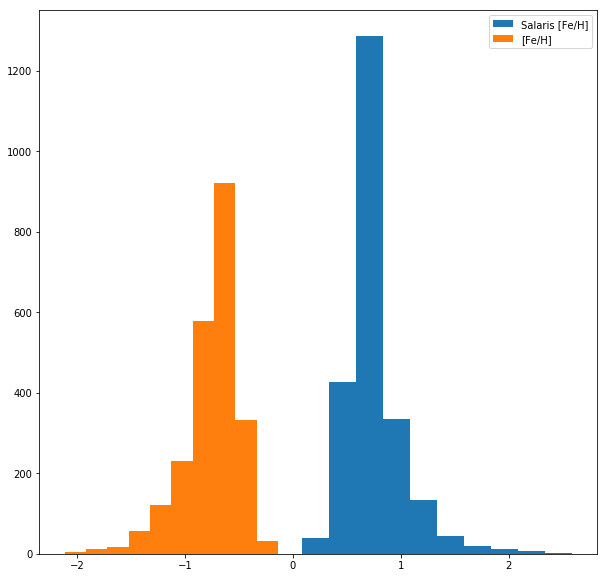

In [80]:
plt.figure(figsize=[10,10])
plt.hist(np.log10(f_fact*(10**(clndr16['ALPHA_M']-clndr16['M_H'])))+clndr16['M_H'],label=r'Salaris [Fe/H]')
plt.hist(clndr16['FE_H'],label=r'[Fe/H]')
plt.legend()
plt.show()

-2.1603079016213993

In [71]:
clndr16['ALPHA_M']+clndr16['M_H']

array([-0.47507334, -1.2713423 , -0.91441935, ..., -0.9188513 ,
       -1.1466793 , -0.90823233], dtype=float32)